In [1]:
## import pickle
import numpy as np
import matplotlib.pyplot as plt
from data.visualise import grid_psfs, show_psf_axial
from tifffile import imread
import pandas as pd
import seaborn as sns

def load_pickle_file(dpath):
    with open(dpath, 'rb') as f:
        return pickle.load(f)

# # MQ_data     
# stacks = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/stacks.ome.tif'
# locs = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/locs.hdf'
# exclude_idx = [5, 7, 11, 14, 22, 24, 26, 27, 28, 31, 32, 35, 37, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]
# Z_STEP = 20

# FD-deeploc data
stacks = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/stacks.ome.tif'
locs = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/locs.hdf'
exclude_idx = []
Z_STEP = 50

psfs = imread(stacks)
locs = pd.read_hdf(locs, key='locs')

psfs = psfs[:, :, :, :, np.newaxis]

print(psfs.shape)

# # for i, psf in enumerate(psfs.sum(axis=-1)):
# #     plt.title(str(i))
# #     show_psf_axial(psf)


# # exclude_idx = [0, 5, 7, 12, 22, 26, 32, 35, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 124, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]

# # print('Excluded PSFs \n\n\n\n\n')
# # for i in exclude_idx:
# #     show_psf_axial(psfs[i].mean(axis=-1), str(i))
# #     plt.plot(psfs[i].max(axis=(1,2)))
# #     plt.show()
# # print('End of excluded PSFs \n\n\n\n\n')

# # print(psfs.shape[0])
# for i in range(psfs.shape[0]):
#     if i in exclude_idx:
#         continue
#     plt.title(str(i))
#     show_psf_axial(psfs[i].mean(axis=-1))
#     plt.plot(psfs[i].max(axis=(1,2,3)), label='max')
#     plt.legend()
#     plt.title(str(i))
#     plt.show()

# idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
# psfs = psfs[idx]
# locs = locs.iloc[idx]
locs['idx'] = np.arange(locs.shape[0])

xlim = ((450, 750))
ylim = ((450, 750))
idx = (xlim[0] < locs['x']) & (locs['x'] < xlim[1]) & (ylim[0] < locs['y']) & (locs['y'] < ylim[1])
locs = locs[idx]
psfs = psfs[locs['idx']]

print(psfs.shape)


ys = []
for i in range(psfs.shape[0]):
    y = np.arange(psfs.shape[1]) * Z_STEP
    y = y - 1000
    ys.append(y)
ys = np.stack(ys)


(6259, 201, 15, 15, 1)
(235, 201, 15, 15, 1)


In [2]:
print(psfs.shape, psfs.min(), psfs.max())
print(ys.shape)
print(locs.shape)

(235, 201, 15, 15, 1) 174 10323
(235, 201)
(235, 14)


In [3]:
from tifffile import imwrite, imread
fname = './tmp.tif'
# imwrite(fname, psfs)

# psfs = imread(fname)

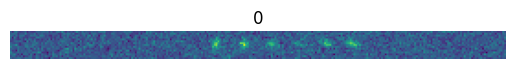

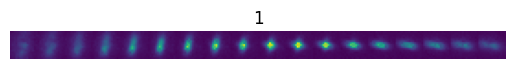

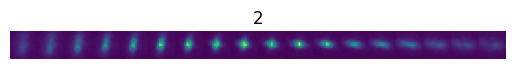

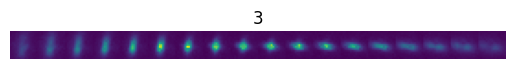

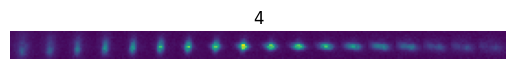

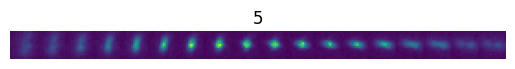

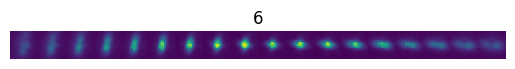

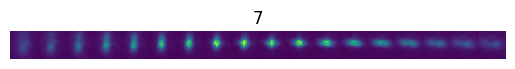

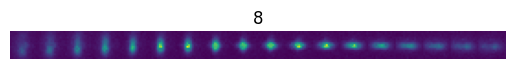

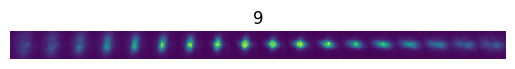

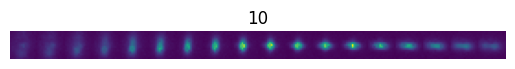

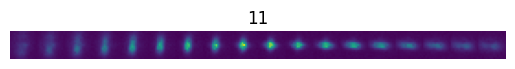

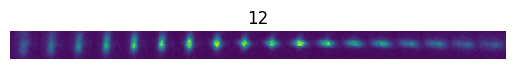

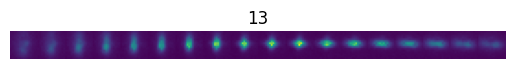

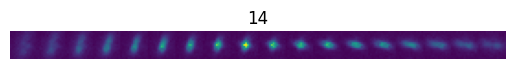

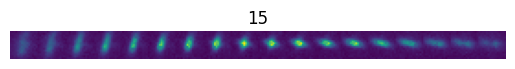

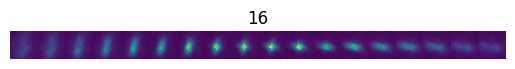

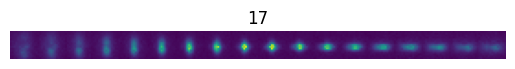

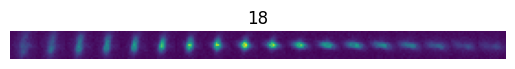

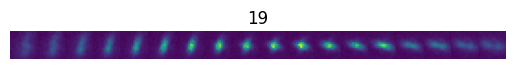

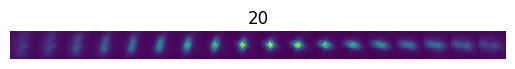

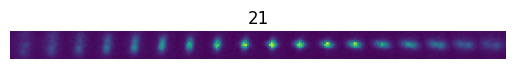

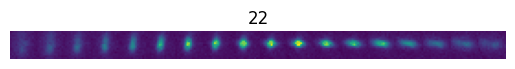

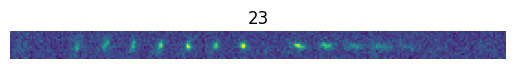

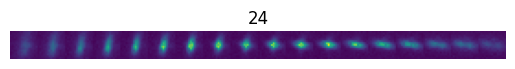

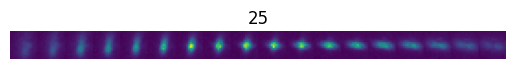

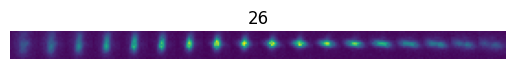

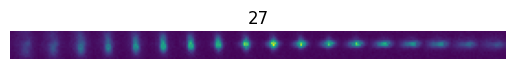

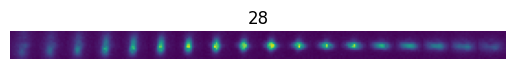

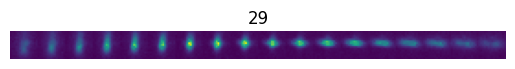

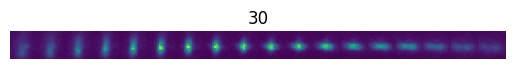

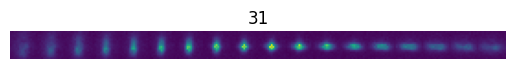

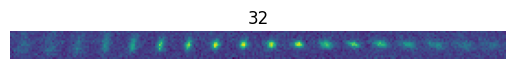

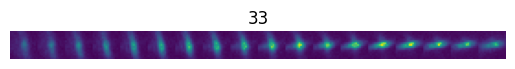

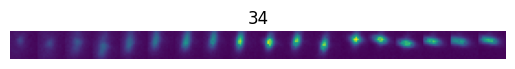

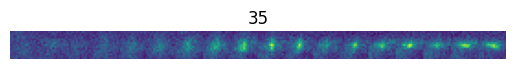

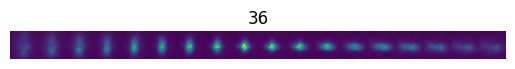

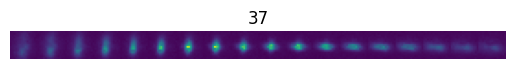

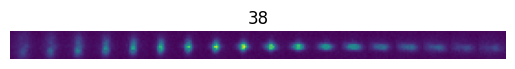

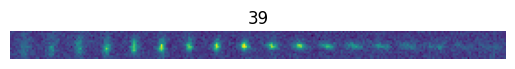

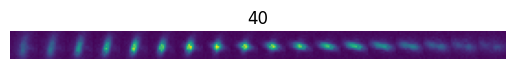

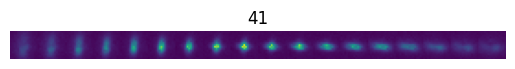

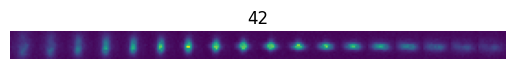

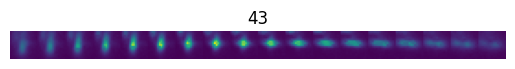

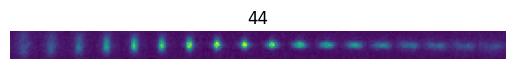

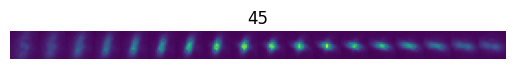

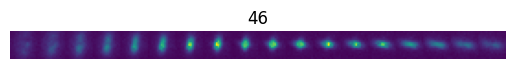

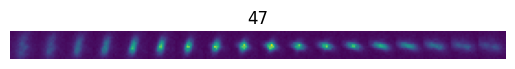

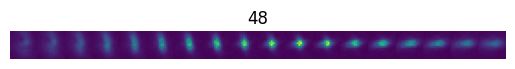

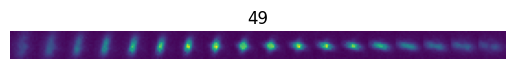

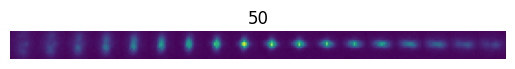

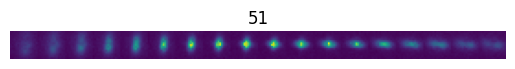

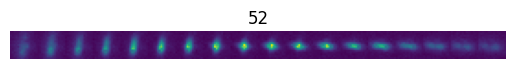

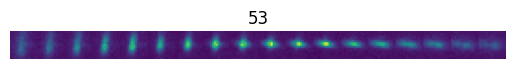

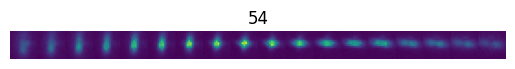

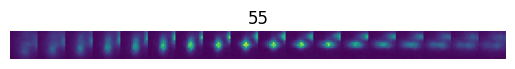

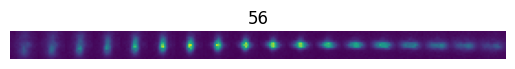

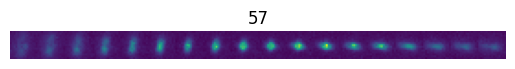

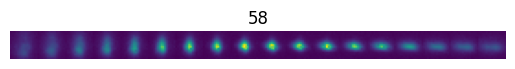

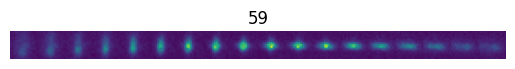

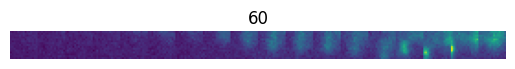

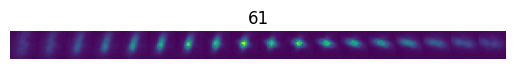

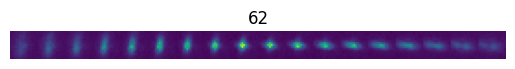

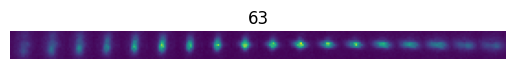

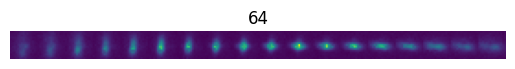

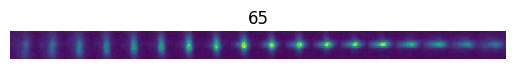

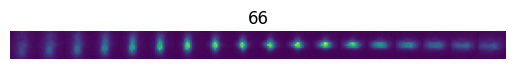

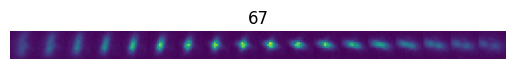

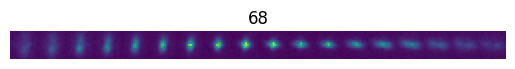

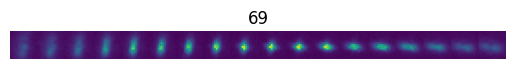

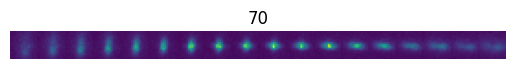

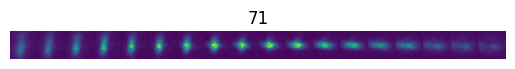

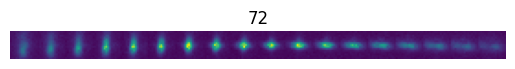

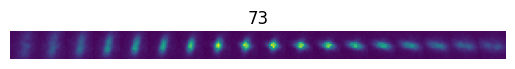

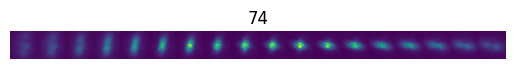

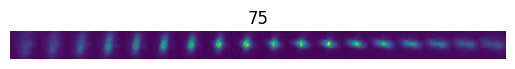

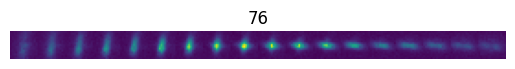

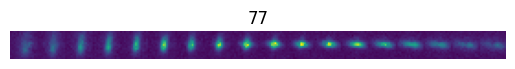

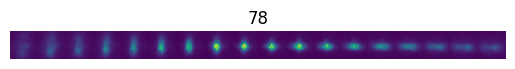

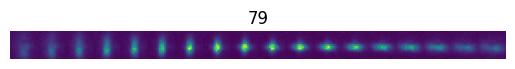

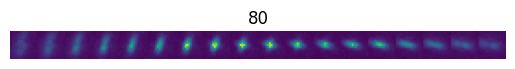

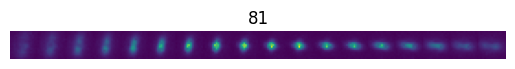

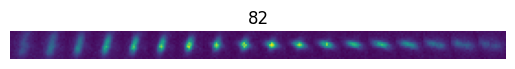

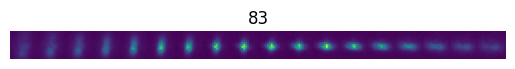

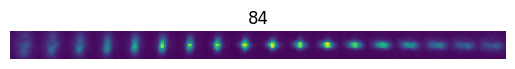

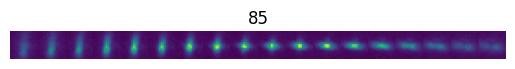

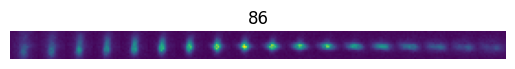

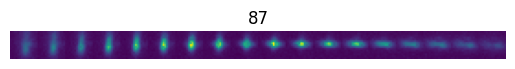

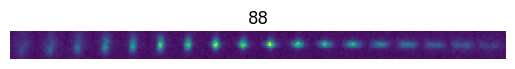

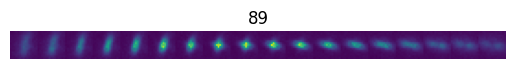

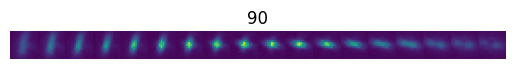

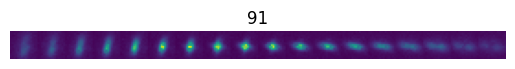

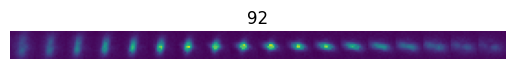

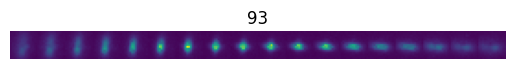

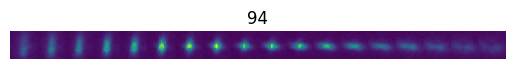

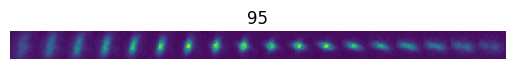

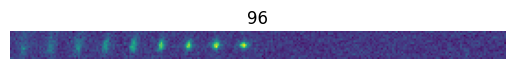

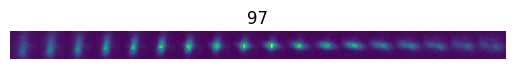

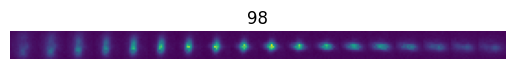

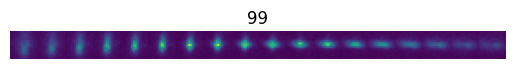

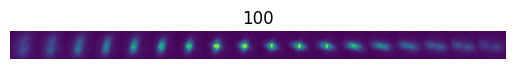

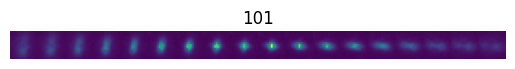

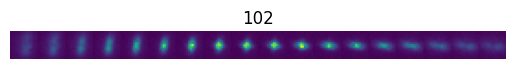

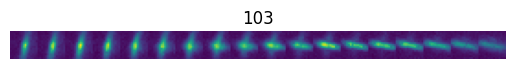

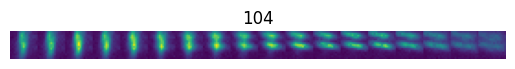

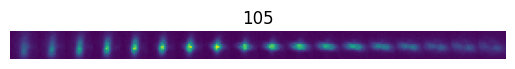

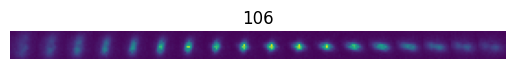

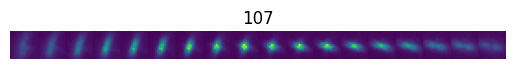

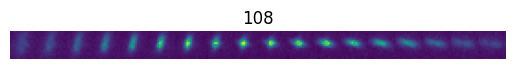

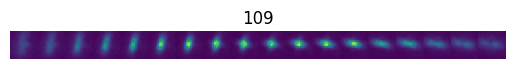

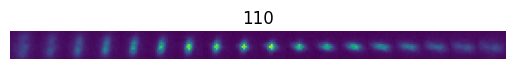

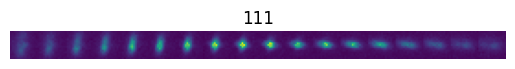

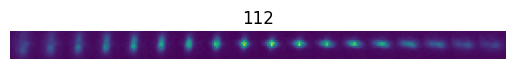

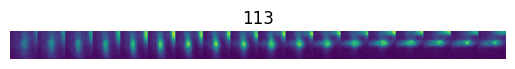

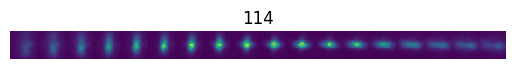

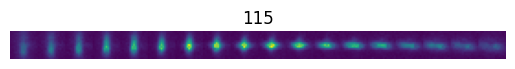

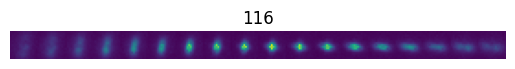

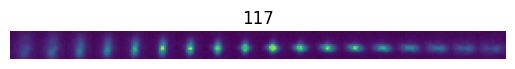

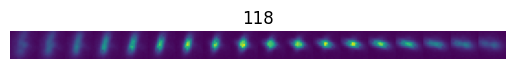

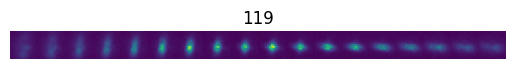

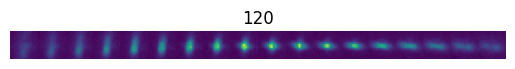

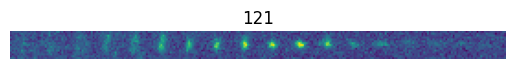

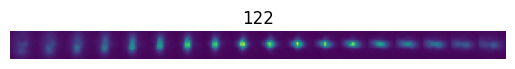

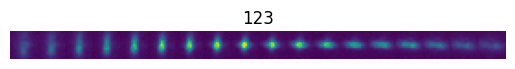

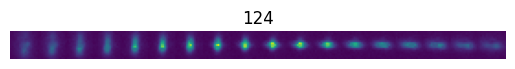

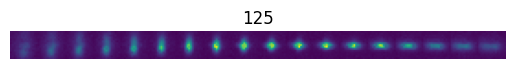

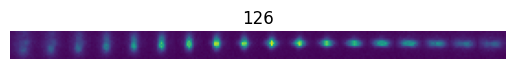

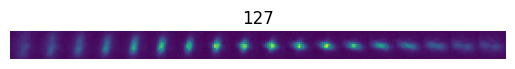

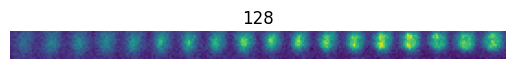

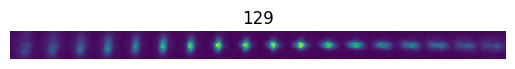

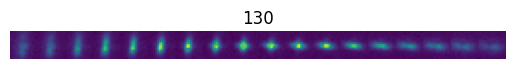

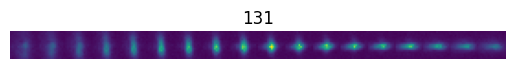

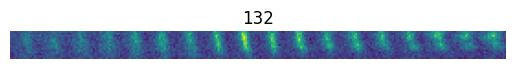

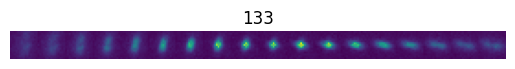

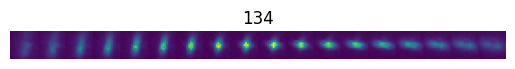

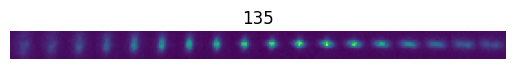

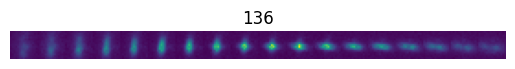

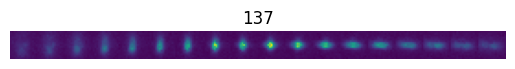

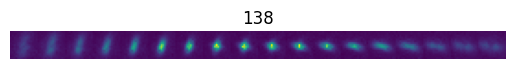

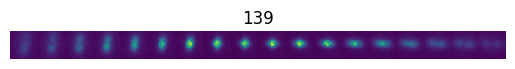

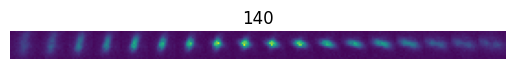

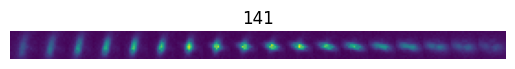

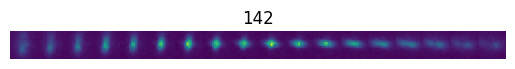

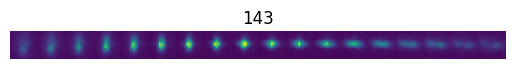

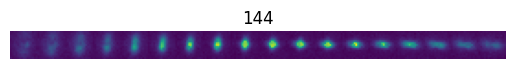

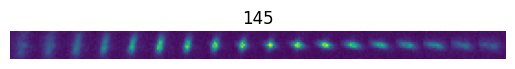

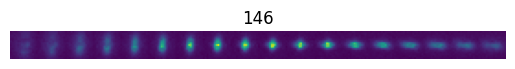

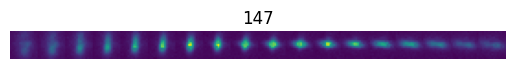

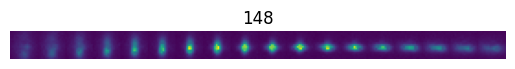

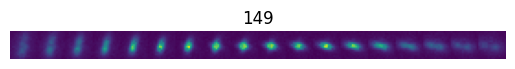

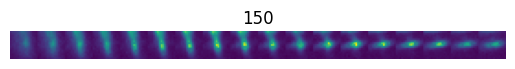

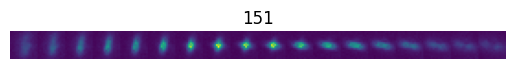

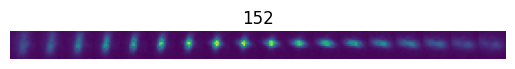

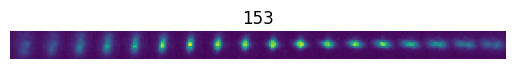

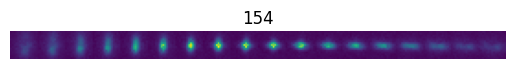

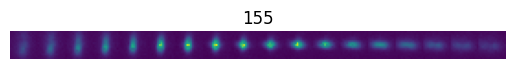

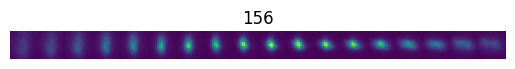

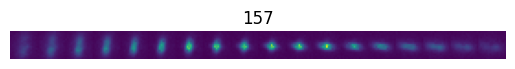

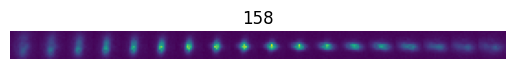

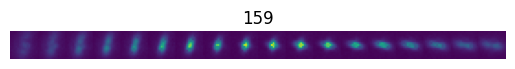

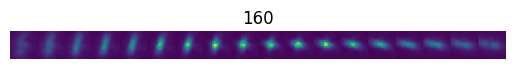

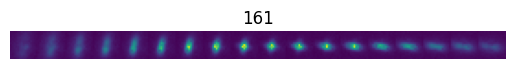

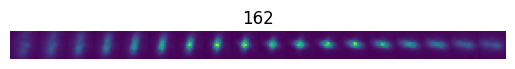

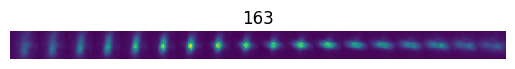

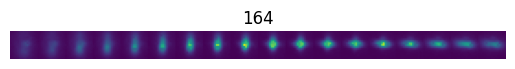

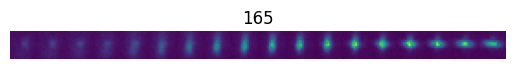

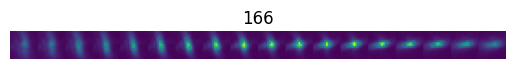

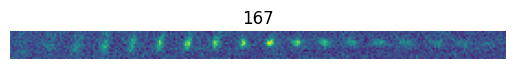

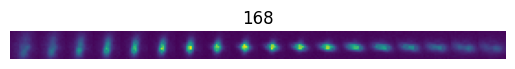

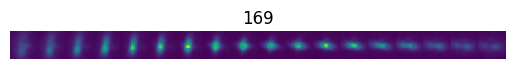

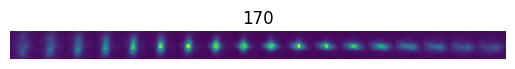

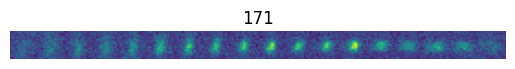

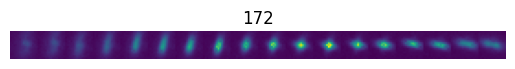

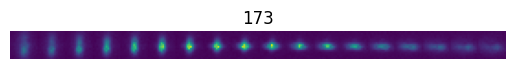

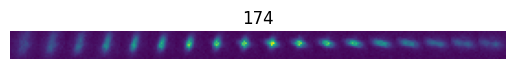

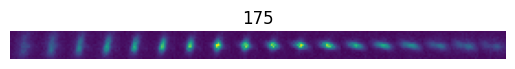

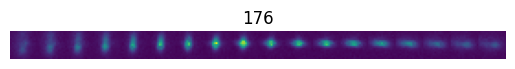

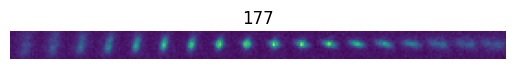

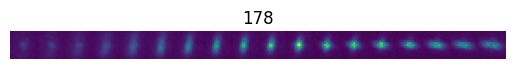

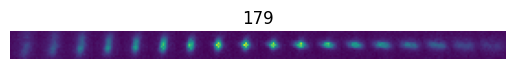

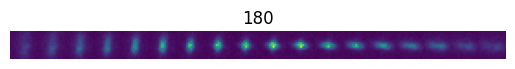

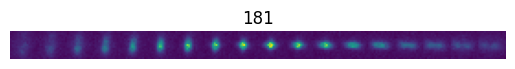

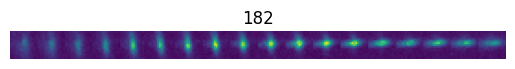

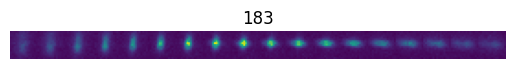

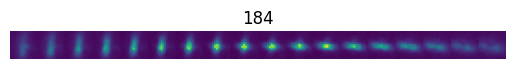

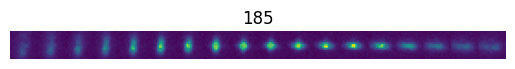

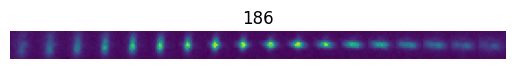

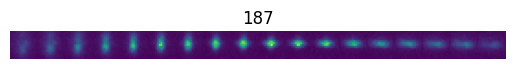

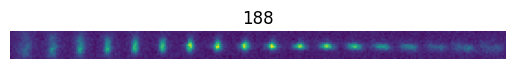

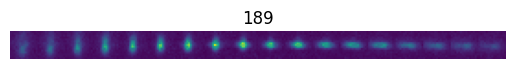

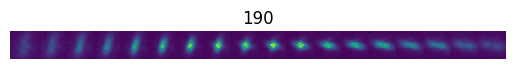

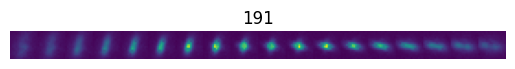

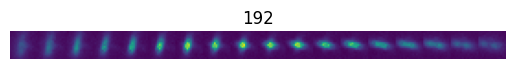

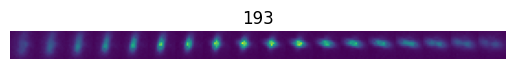

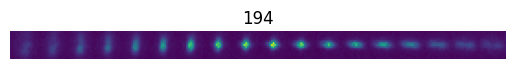

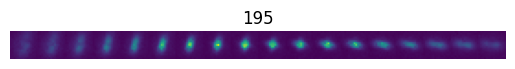

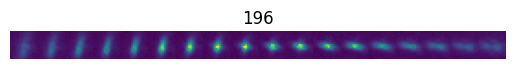

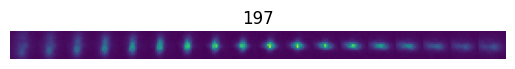

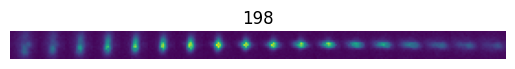

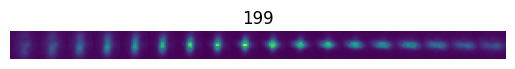

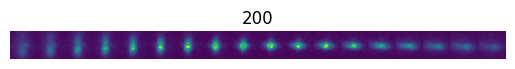

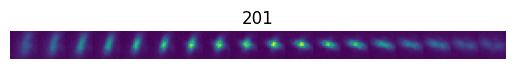

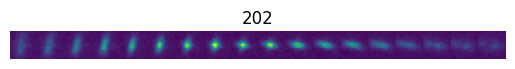

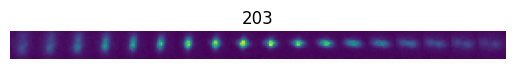

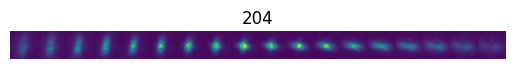

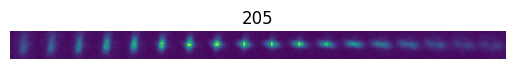

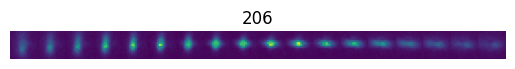

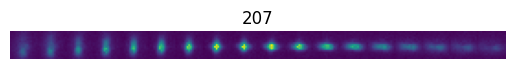

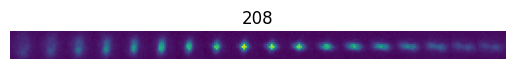

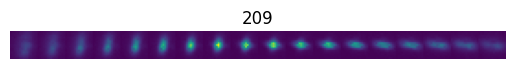

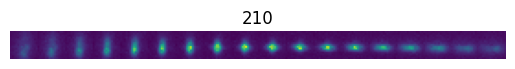

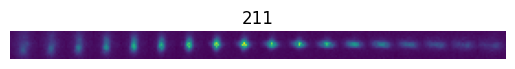

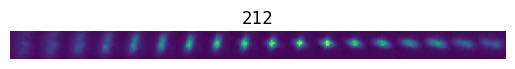

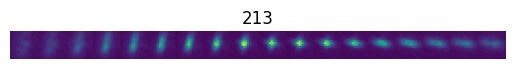

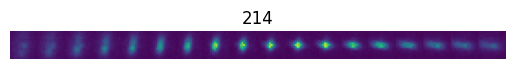

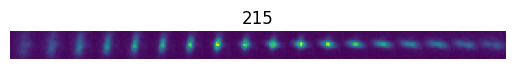

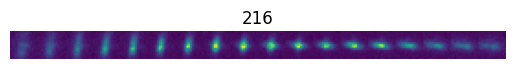

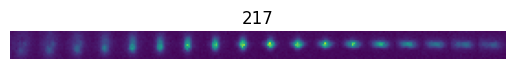

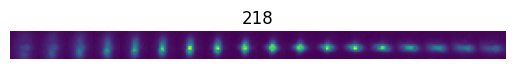

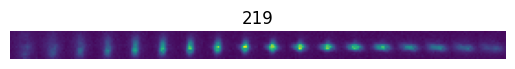

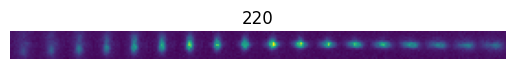

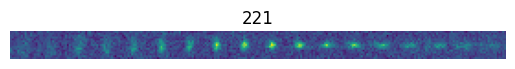

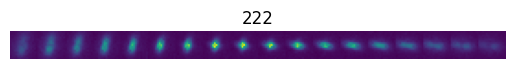

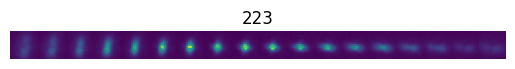

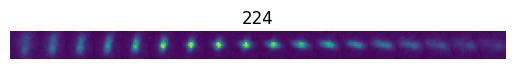

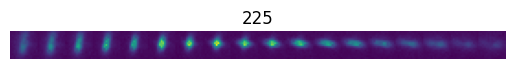

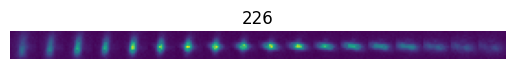

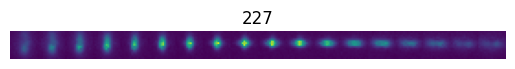

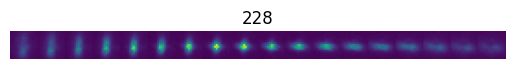

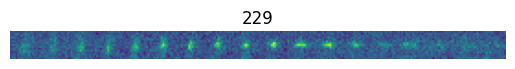

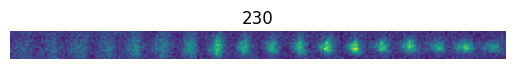

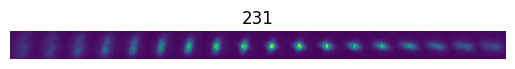

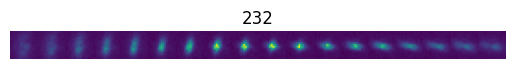

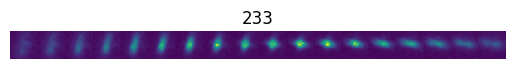

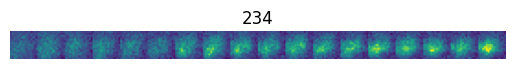

In [4]:
from data.visualise import show_psf_axial
for i, psf in enumerate(psfs):
    show_psf_axial(psf.mean(axis=-1), str(i))

In [5]:
# # for fov xy (650, 850), (650, 850)
# exclude_idx = [24, 26, 40, 42, 49, 98, 120]

# # for fov xy (0, 300) (0, 300)
# # exclude_idx = [35, 153, 190, 204, ]

# # for fov xy (0, 450) (0, 450)
# # exclude_idx = [98, 104, 120, 209, 277, 312, 334, 358, 366, 400, 404, 439, 447, 458, 483, 486]
# idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
# psfs = psfs[idx]
# locs = locs.iloc[idx]

In [6]:
# Spline peak finding
from tqdm import tqdm
import numpy as np
Z_STEP = 50

from scipy.interpolate import UnivariateSpline
from data.align_psfs import norm_zero_one
from skimage.filters import gaussian

UPSCALE_RATIO = 10

def find_peak(psf):
    if psf.ndim == 4:
        psf = psf.mean(axis=-1)
    x = np.arange(psf.shape[0]) * Z_STEP
    inten = norm_zero_one(gaussian(psf).max(axis=(1,2)))
#   prev 0.8
    cs = UnivariateSpline(x, inten, k=3, s=1.25)

    x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP
    
    peak = x_ups[np.argmax(cs(x_ups))] 
    
#     plt.plot(x-peak, inten, label='raw')
#     plt.plot(x_ups-peak, cs(x_ups), label='fit')
#     plt.legend()
#     plt.show()
    return peak

offsets = np.zeros((psfs.shape[0]))
# offsets = np.array([find_peak(psf) for psf in tqdm(psfs)])


2023-08-07 14:29:32.410115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:29:32.905276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:

ys = []
for i, offset in enumerate(offsets):
    zs = ((np.arange(psfs.shape[1])) * Z_STEP) - offset
    ys.append(zs)

ys = np.array(ys)


In [8]:
print(psfs.shape)
print(ys.shape)


(235, 201, 15, 15, 1)
(235, 201)


In [9]:
# Withold some PSFs for evaluation

from sklearn.model_selection import train_test_split

SEED = 42

idx = np.arange(psfs.shape[0])

# train_idx, test_idx = train_test_split(idx, train_size=0.9, random_state=SEED, stratify=locs['group'])
train_idx, test_idx = train_test_split(idx, train_size=0.9, random_state=SEED)

_train_val_psfs = psfs[train_idx]
test_psfs = psfs[test_idx]

_train_val_ys = ys[train_idx]
test_ys = ys[test_idx]

# train_fov_groups = locs['group'].to_numpy()[train_idx]

# ds_cls = np.zeros((psfs.shape[0]), dtype=object)
# ds_cls[train_idx] = 'train/val'
# ds_cls[test_idx] = 'test'
# locs['ds'] = ds_cls

# sns.scatterplot(data=locs, x='x', y='y', hue='ds')
# plt.show()

In [10]:

groups = np.repeat(np.arange(len(train_idx))[:, np.newaxis], psfs.shape[1], axis=1).flatten()

train_val_psfs = np.concatenate(_train_val_psfs)
train_val_ys = np.concatenate(_train_val_ys)
split_idx = np.arange(train_val_psfs.shape[0])

train_idx, val_idx = train_test_split(split_idx, train_size=0.9, random_state=SEED, stratify=groups, shuffle=True)

train_psfs = train_val_psfs[train_idx]
train_ys = train_val_ys[train_idx][:, np.newaxis]
_train_groups = groups[train_idx][:, np.newaxis]

val_psfs = train_val_psfs[val_idx]
val_ys = train_val_ys[val_idx][:, np.newaxis]
_val_groups = groups[val_idx][:, np.newaxis]



In [11]:
print(train_psfs.shape, train_ys.shape, _train_groups.shape)
print(val_psfs.shape, val_ys.shape, _val_groups.shape)


(38169, 15, 15, 1) (38169, 1) (38169, 1)
(4242, 15, 15, 1) (4242, 1) (4242, 1)


In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder().fit(_train_groups)

train_groups = encoder.transform(_train_groups).toarray()
val_groups = encoder.transform(_val_groups).toarray()

print(train_psfs.shape, train_ys.shape, train_groups.shape)
print(val_psfs.shape, val_ys.shape, val_groups.shape)


(38169, 15, 15, 1) (38169, 1) (38169, 211)
(4242, 15, 15, 1) (4242, 1) (4242, 211)


In [13]:
print(train_groups[0:10, 0:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
# Trim stacks

def filter_z_range(X, zs):
    psfs, groups = X
    valid_ids = np.argwhere(abs(zs.squeeze()) < Z_RANGE).squeeze()
    return [psfs[valid_ids], groups[valid_ids]], zs[valid_ids]
    
Z_RANGE = 1000
X_train, y_train = filter_z_range((train_psfs, train_groups), train_ys)

X_val, y_val = filter_z_range((val_psfs, val_groups), val_ys)


In [15]:
from skimage.transform import resize
from tqdm import tqdm

def resize_psfs(X):
    target_size = 128
    imshape = (target_size, target_size, 3)
    X[0] = np.stack([resize(psf, imshape) for psf in tqdm(X[0])])
    print(X[0].shape)

resize_psfs(X_train)
resize_psfs(X_val)

 10%|████                                     | 41/414 [00:00<00:00, 405.04it/s]

(3806, 128, 128, 3)


100%|████████████████████████████████████████| 414/414 [00:01<00:00, 408.28it/s]

(414, 128, 128, 3)


In [16]:
print(X_train[0].shape, X_train[1].shape, y_train.shape)
print(X_val[0].shape, X_val[1].shape, y_val.shape)


(3806, 128, 128, 3) (3806, 211) (3806, 1)
(414, 128, 128, 3) (414, 211) (414, 1)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/65336.0,
    samplewise_center=False,
    samplewise_std_normalization=False,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False)

print('Fitting datagen...')
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train[0])
print('Fitted')

X_train_preproc = [X_train[0].copy(), X_train[1].copy()]
X_val_preproc = [X_val[0].copy(), X_val[1].copy()]

X_train_preproc[0] = datagen.standardize(X_train_preproc[0])
X_val_preproc[0] = datagen.standardize(X_val_preproc[0])

# preprocessors = {
#     'psfs': datagen,
#     'coords': coords_scaler
# }

# import pickle
# with open('./scalers.p', 'wb') as f:
#     pickle.dump(preprocessors, f)

Fitting datagen...
Fitted


In [18]:
test_psfs = psfs[test_idx]

test_ys = ys[test_idx]

test_groups = np.repeat(np.arange(len(test_psfs))[:, np.newaxis], test_psfs.shape[1], axis=1)

test_psfs = np.concatenate(test_psfs)

test_ys = np.concatenate(test_ys)[:, np.newaxis]
test_groups = np.concatenate(test_groups)

X_test, y_test = filter_z_range((test_psfs, test_groups), test_ys)

test_groups = X_test[1].copy()

X_test[1] = np.zeros((X_test[0].shape[0], X_val[1].shape[1]))
resize_psfs(X_test)
X_test_preproc = [X_test[0].copy(), X_test[1].copy()]
X_test_preproc[0] = datagen.standardize(X_test_preproc[0])


100%|████████████████████████████████████████| 480/480 [00:01<00:00, 410.84it/s]


(480, 128, 128, 3)


In [33]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras import regularizers

import tensorflow as tf

def train_model(X_train_preproc, y_train, X_val_preproc, y_val):
    img_input = layers.Input((X_train_preproc[0][0].shape))
    coords_input = layers.Input(X_train_preproc[1][0].shape)
    
    coords_emb = layers.Dense(64)(coords_input)
    x = img_input
    
#     x = keras.applications.ResNet50V2(
#         input_tensor = img_input,
#         include_top=False,
#         pooling='avg',
#         weights='imagenet',
#     )(x)

#     x = keras.applications.MobileNetV3Small(
#         input_tensor=img_input,
#         include_top=False,
#         pooling='avg',
#     )(x)
    x = keras.applications.MobileNet(
        input_tensor=img_input,
        include_top=False,
        weights='../mobilenet_1_0_128_tf_no_top.h5',
        pooling='max',
    )(x)

    x = tf.concat([x, coords_emb], axis=-1)
    
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation="linear",
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                       bias_regularizer=regularizers.L2(1e-4),
                       activity_regularizer=regularizers.L2(1e-5)
                      )(x)

    model = keras.Model(inputs=(img_input, coords_input), outputs=out)

    model.summary(expand_nested=False)


    batch_size = 256
    epochs = 5000
    lr = 0.001

    model.compile(loss='mean_squared_error', optimizer=optimizers.AdamW(learning_rate=lr), metrics=['mean_absolute_error'])

    callbacks = [
        ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1,
                          patience=50, verbose=True, mode='min', min_delta=1, min_lr=1e-6,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=75,
                      verbose=False, min_delta=1, restore_best_weights=True),
        TqdmCallback(verbose=1),
    ]


    history = model.fit(X_train_preproc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_preproc, y_val), callbacks=callbacks, shuffle=True, verbose=False)

    model.save('./latest_model')
    return model, history

# X_train_preproc[1][:] = 0
# X_val_preproc[1][:] = 0
model, history = train_model(X_train_preproc, y_train, X_val_preproc, y_val)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 211)]        0           []                               
                                                                                                  
 mobilenet_1.00_None (Functiona  (None, 1024)        3228864     ['input_3[0][0]']                
 l)                                                                                               
                                                                                            


Epoch 116: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.



INFO:tensorflow:Assets written to: ./latest_model/assets


INFO:tensorflow:Assets written to: ./latest_model/assets


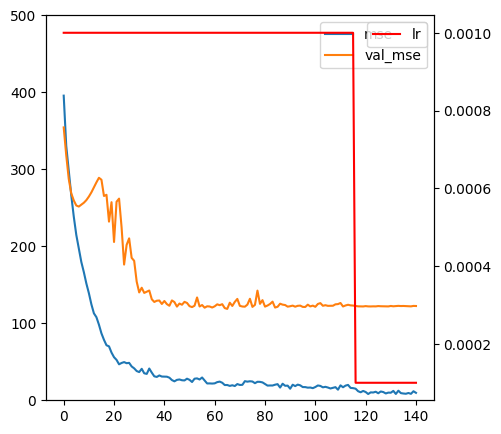

In [34]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax1 = plt.subplots()
ax1.plot(history.history['mean_absolute_error'], label='mse')
ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
ax1.set_ylim([0, 500])
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(history.history['lr'], label='lr', color='red')
ax2.legend(loc=0)


In [21]:
from sklearn.metrics import mean_absolute_error
ds = [
    ('train', (X_train_preproc, y_train)), 
    ('val', (X_val_preproc, y_val)),
    ('test', (X_test_preproc, y_test))
]
for k, (X, y) in ds:
    res = model.predict(X, verbose=True)
    error = mean_absolute_error(res, y)
    print(k, round(error, 3))

119/119 [==============================] - 1s 4ms/step
train 33.663
13/13 [==============================] - 0s 4ms/step
val 126.073
15/15 [==============================] - 0s 4ms/step
test 140.363


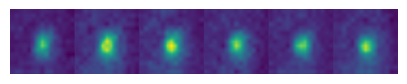

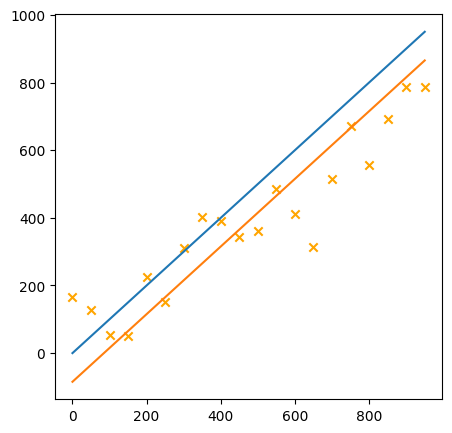

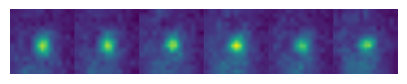

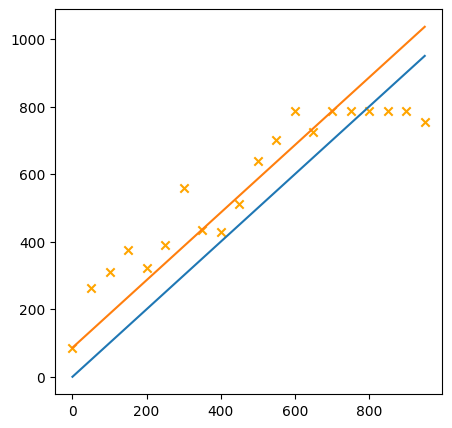

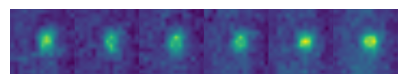

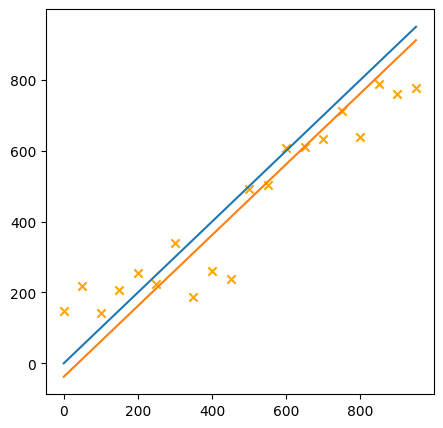

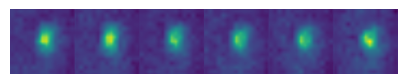

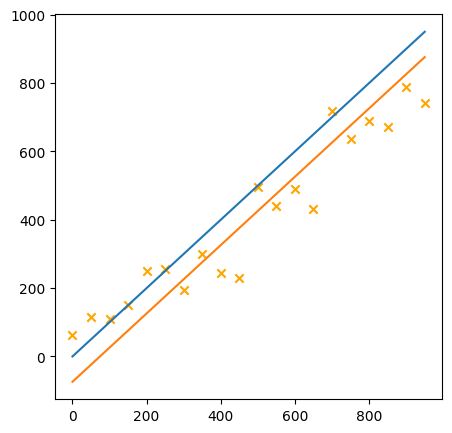

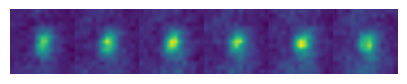

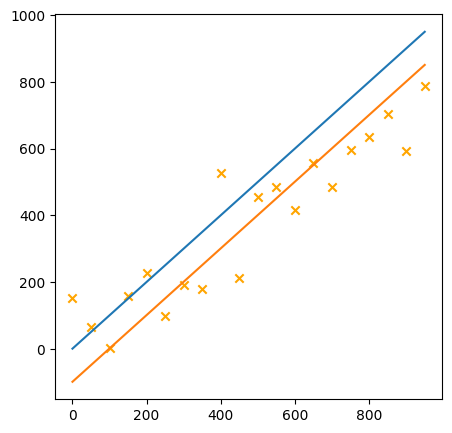

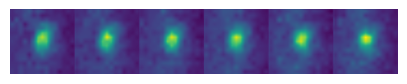

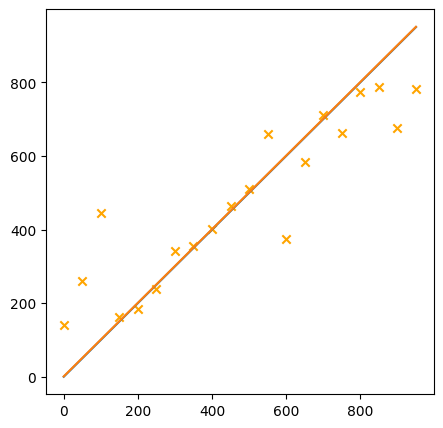

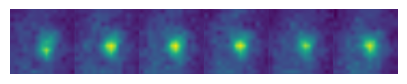

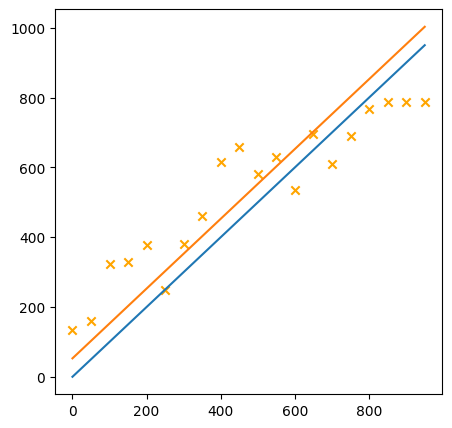

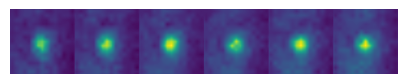

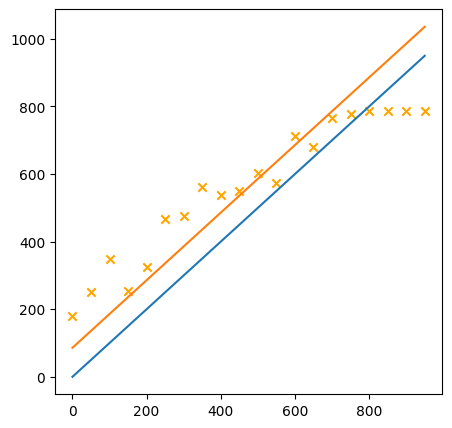

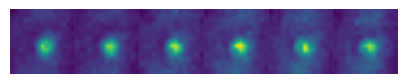

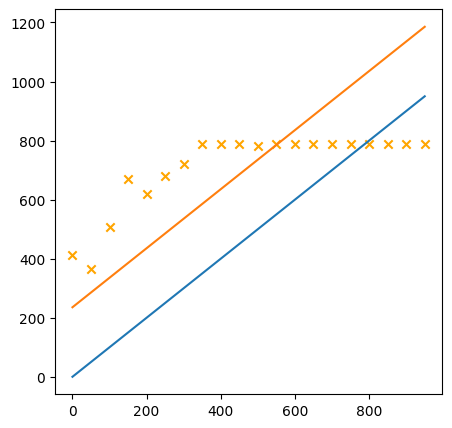

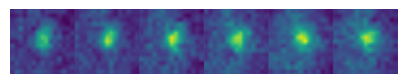

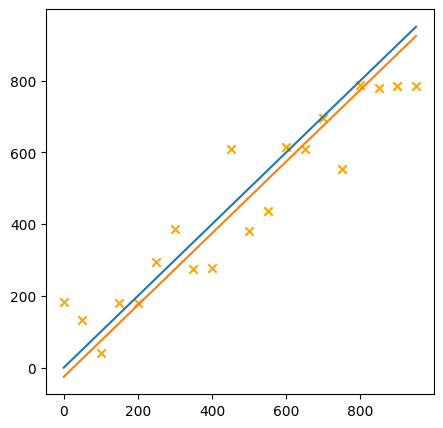

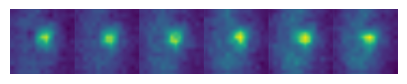

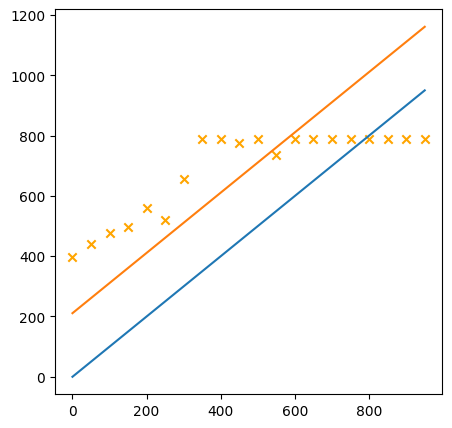

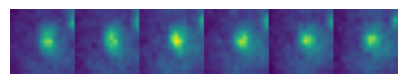

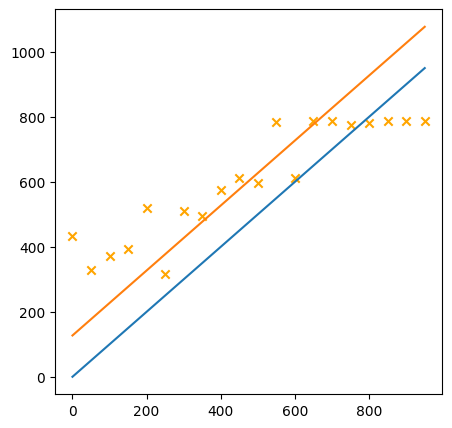

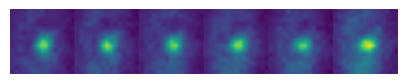

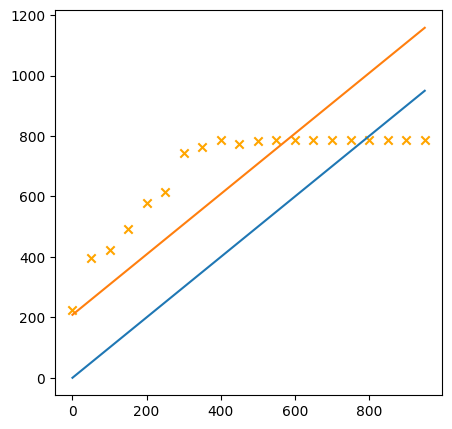

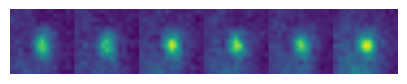

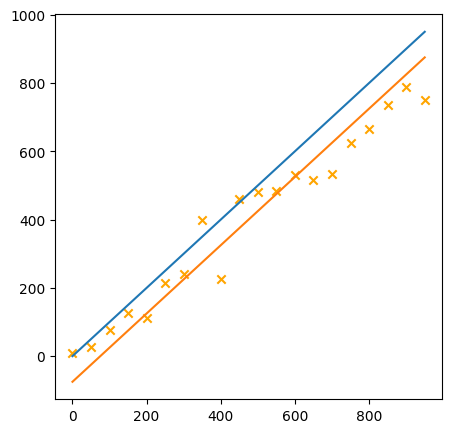

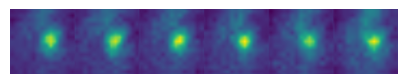

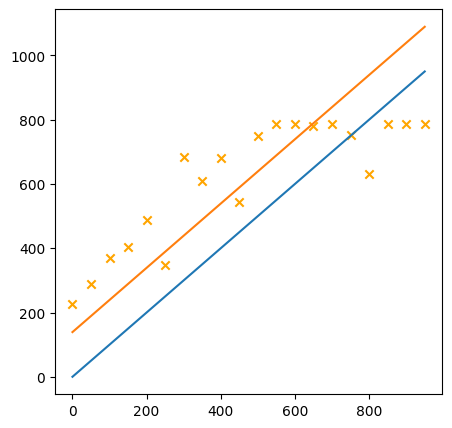

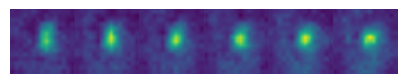

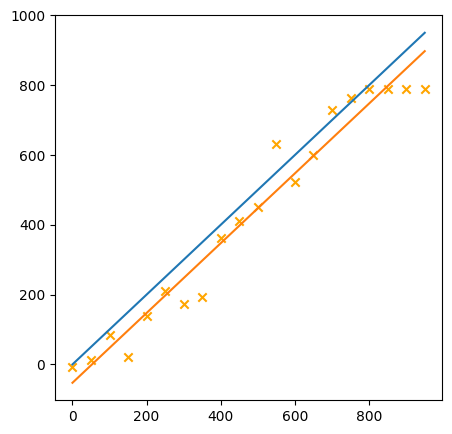

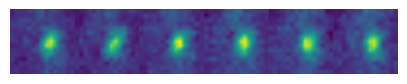

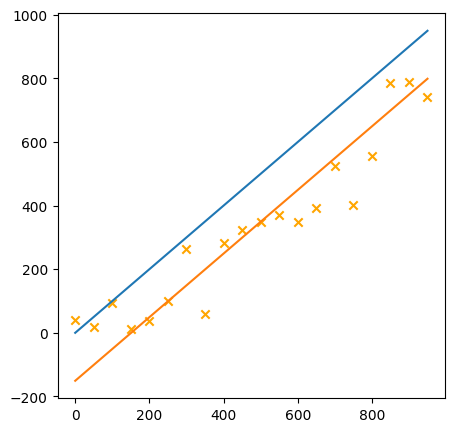

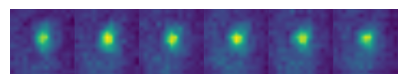

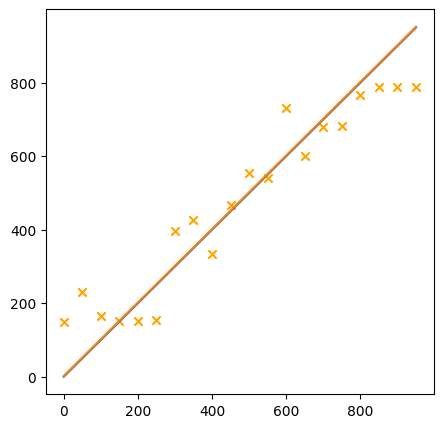

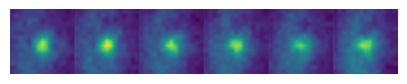

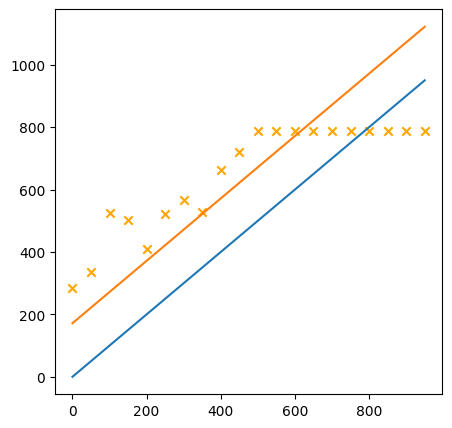

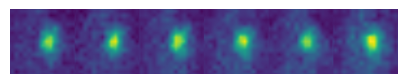

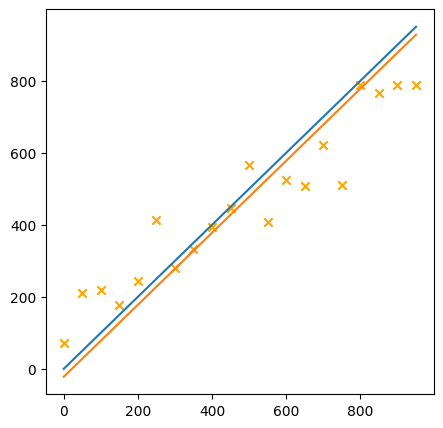

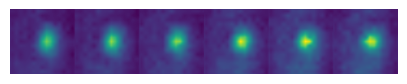

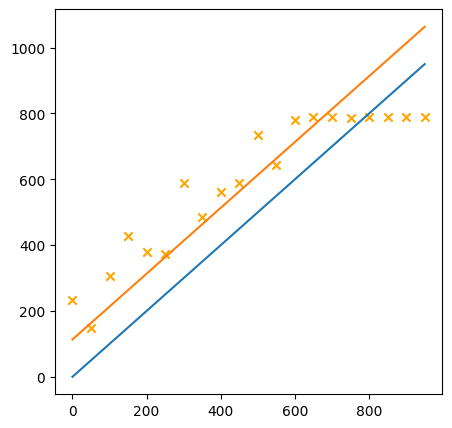

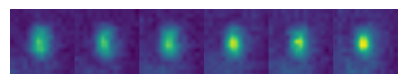

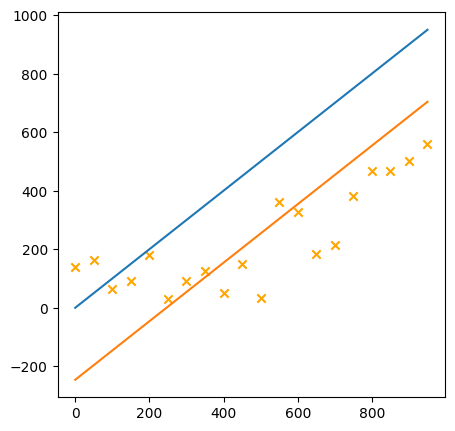

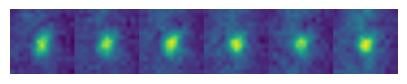

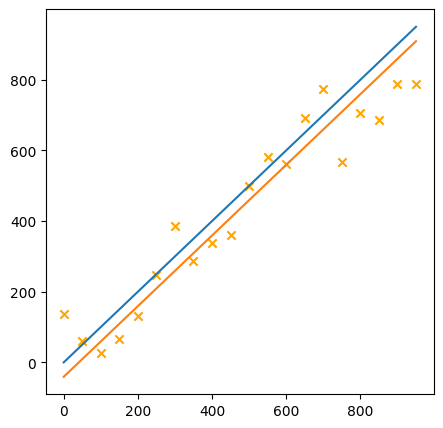

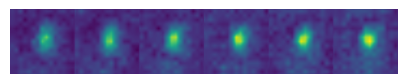

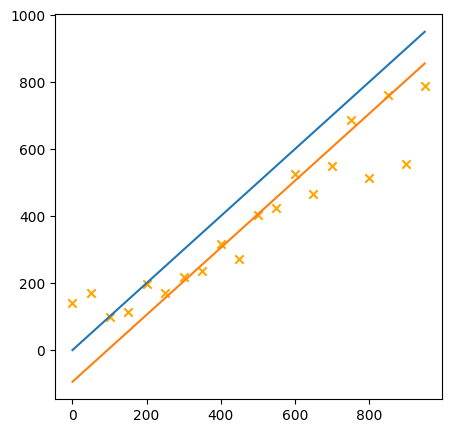

test 100.493


In [22]:
# MAE without located error
import scipy.optimize as opt

def bestfit_error(z_true, z_pred):

    def linfit(x, c):
        return x + c

    x = z_true
    y = z_pred
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    error = mean_absolute_error(y_fit, y)
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')
    plt.scatter(z_true, z_pred, marker='x', c='orange')
    plt.show()
    return error, popt[0], y_fit-y

ds = [
    ('test', (X_test_preproc, y_test))
]

res = {}
for k, (X, y) in ds:
    pred_z = model.predict(X, verbose=False)
    res[k] = []
    if k in 'test':
        groups = test_groups
    else:
        groups = encoder.inverse_transform(X[1]).squeeze()
    y = y.squeeze()
    for g in set(groups):
        idx = np.argwhere(groups==g)[:, 0]
        group_psfs = X[0][idx]
        show_psf_axial(group_psfs.mean(axis=-1), '', 2)
        group_true_zs = y[idx]
        group_pred_zs = pred_z[idx][:, 0]
        if len(idx) == 1:
            res[k].append([mean_absolute_error(group_true_zs, group_pred_zs)])
        else:
            error, offset, errors = bestfit_error(group_true_zs, group_pred_zs)
            res[k].extend(errors)

for k, v in res.items():
    print(k, round(np.mean(np.abs(v)), 3))

In [23]:
# Results
# w/               groups    no groups   no groups larger FOV
# train            18.952    11.403      12
# val              55.52     53.929      68
# test             102.356   99.47       74
# test_wo_offsets  48.838    48.318      42

# w/ No reg        no groups / alignment   No groups / no alignment
# train            14____                  ______         
# val              43____                  ______         
# test             93.8__                  ______         
# test_wo_offsets  51.8__                  ______         


15/15 [==============================] - 0s 4ms/step
(480, 1) (480,) (480,)


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


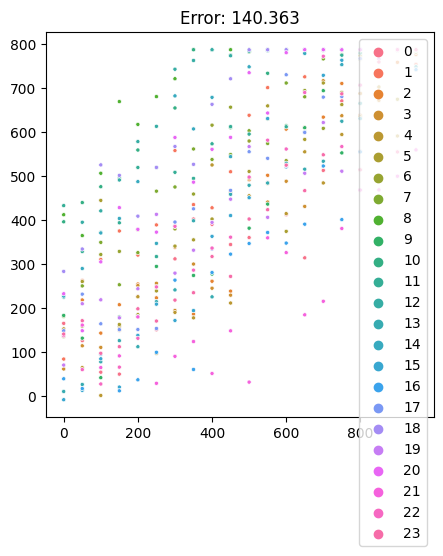

In [24]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
pred_zs = model.predict(X_test_preproc).squeeze()

error = mean_absolute_error(y_test, pred_zs)

print(y_test.shape, pred_zs.shape, test_groups.shape)
plt.title(f'Error: {round(error, 3)}')
sns.scatterplot(y_test.squeeze(), pred_zs.squeeze(), hue=test_groups.astype(str), marker='.')
# sns.plot([-1000, -1000], [1000, 1000], c='orange', label='y=x')
plt.show()



1/1 [==============================] - 0s 33ms/step


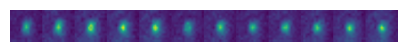

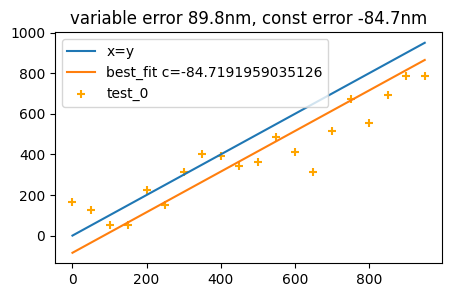

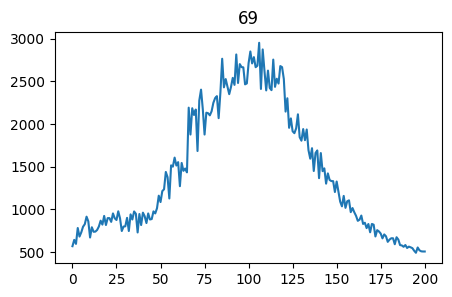

1/1 [==============================] - 0s 13ms/step


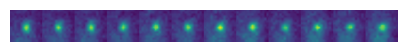

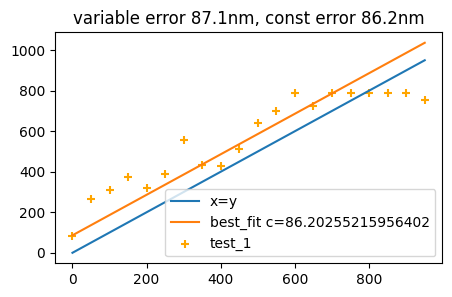

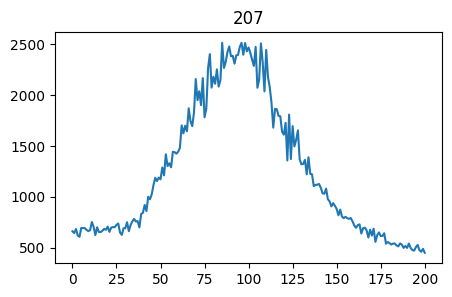

1/1 [==============================] - 0s 13ms/step


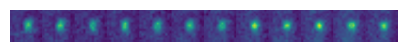

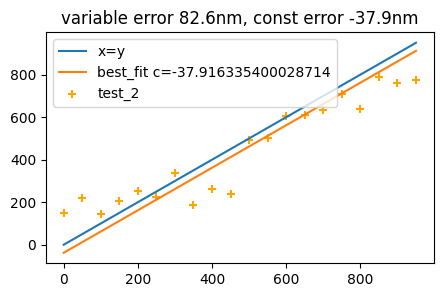

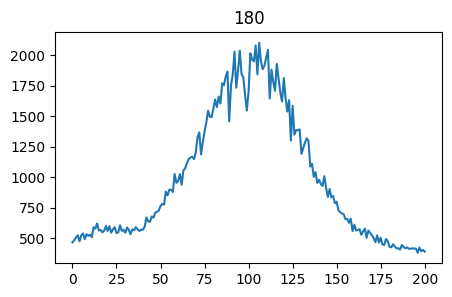

1/1 [==============================] - 0s 13ms/step


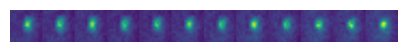

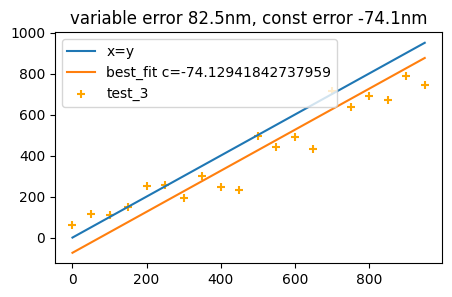

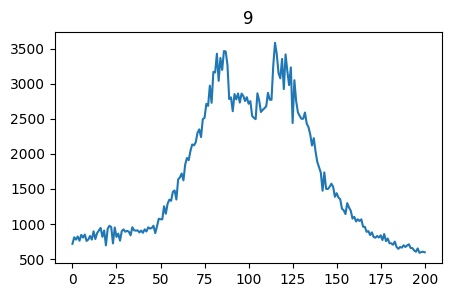

1/1 [==============================] - 0s 13ms/step


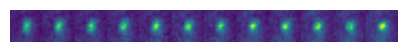

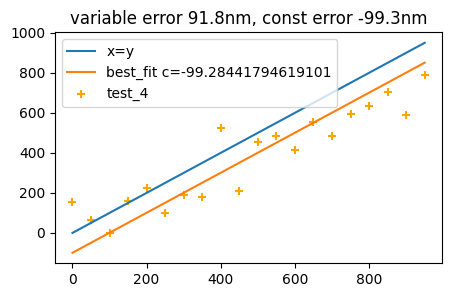

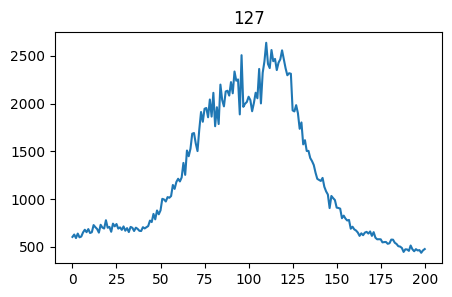

1/1 [==============================] - 0s 13ms/step


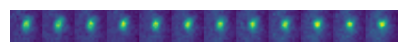

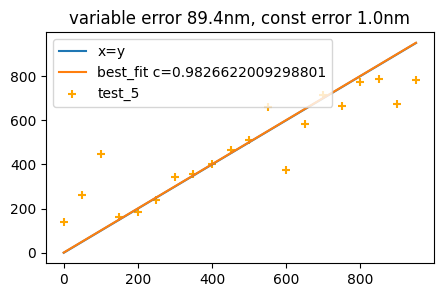

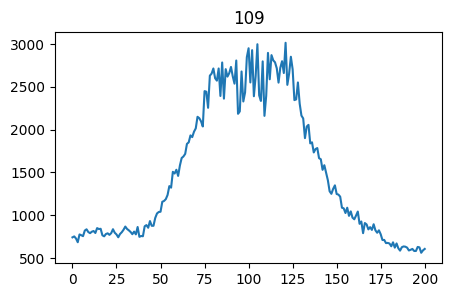

1/1 [==============================] - 0s 13ms/step


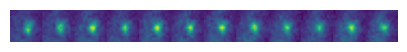

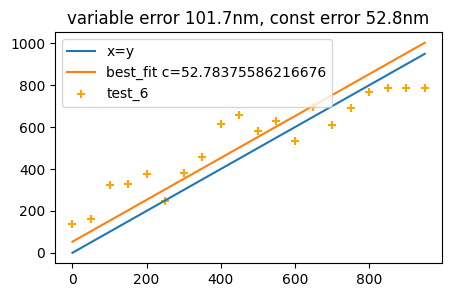

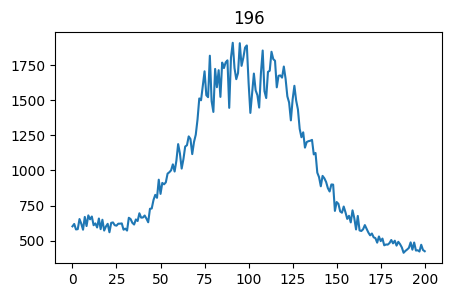

1/1 [==============================] - 0s 13ms/step


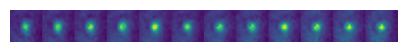

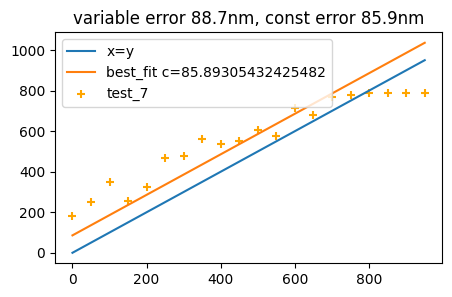

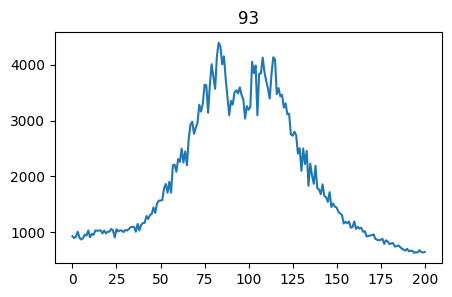

1/1 [==============================] - 0s 13ms/step


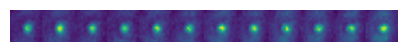

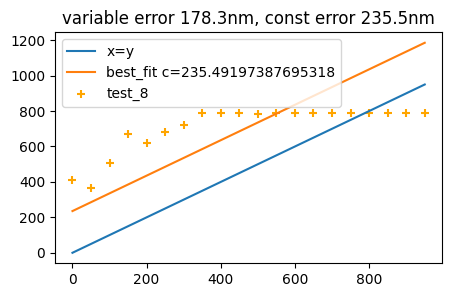

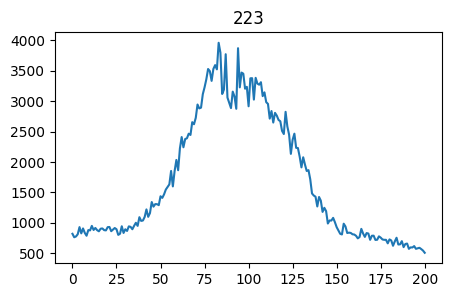

1/1 [==============================] - 0s 15ms/step


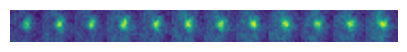

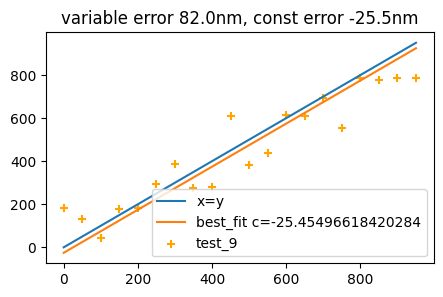

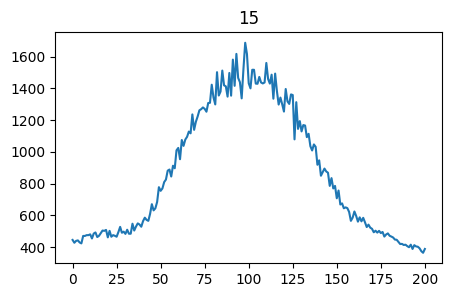

1/1 [==============================] - 0s 15ms/step


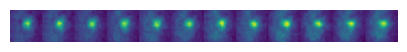

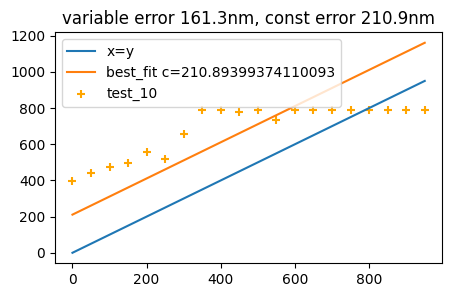

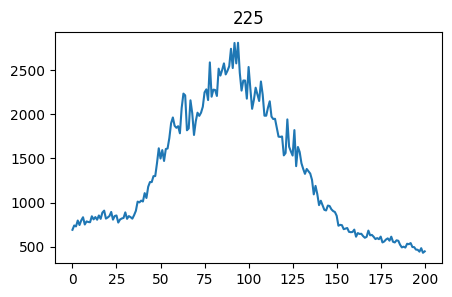

1/1 [==============================] - 0s 15ms/step


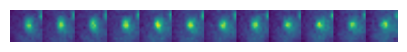

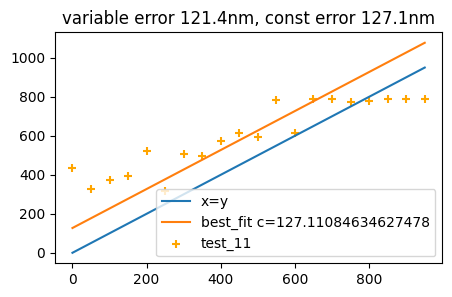

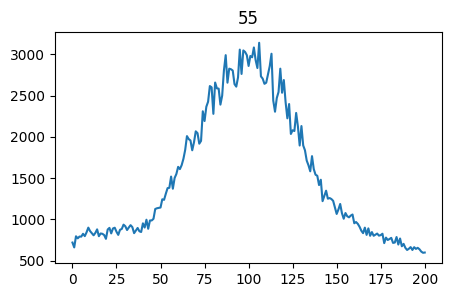

1/1 [==============================] - 0s 14ms/step


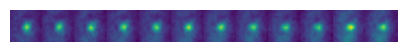

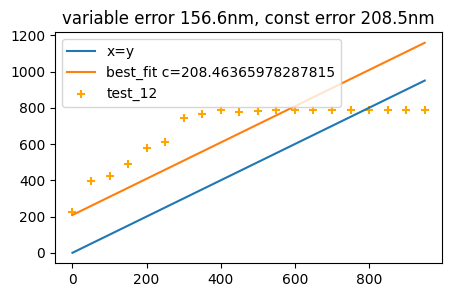

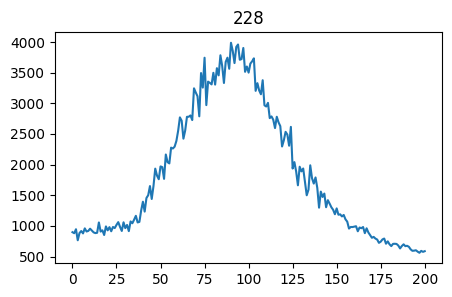

1/1 [==============================] - 0s 14ms/step


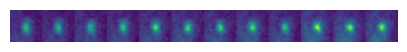

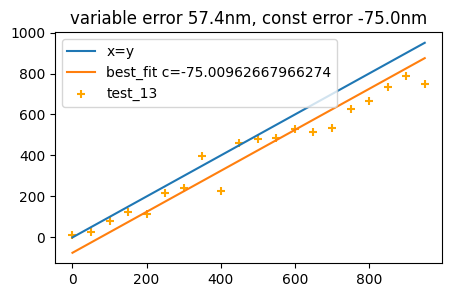

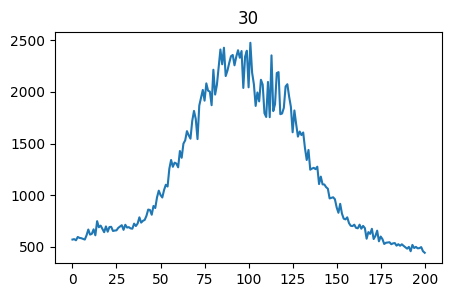

1/1 [==============================] - 0s 15ms/step


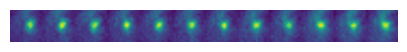

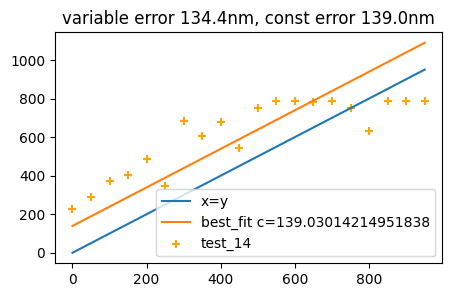

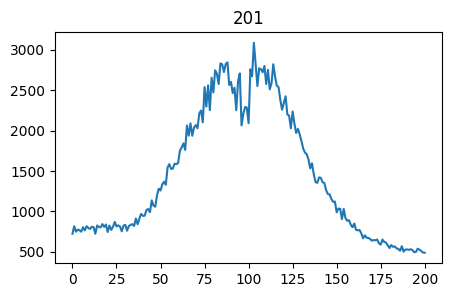

1/1 [==============================] - 0s 14ms/step


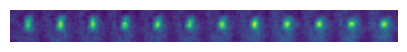

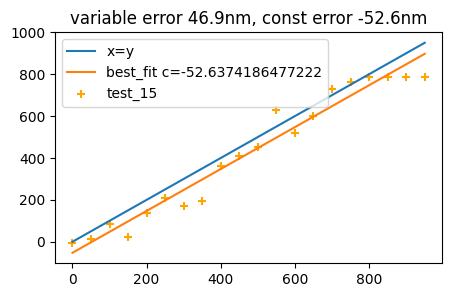

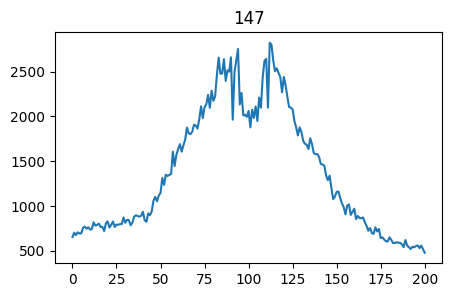

1/1 [==============================] - 0s 14ms/step


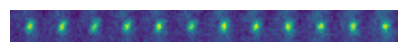

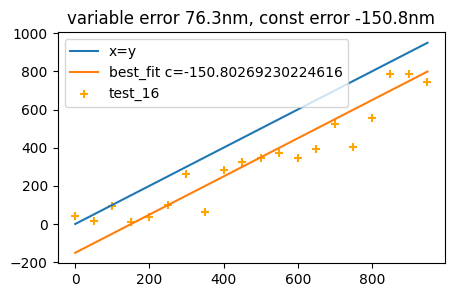

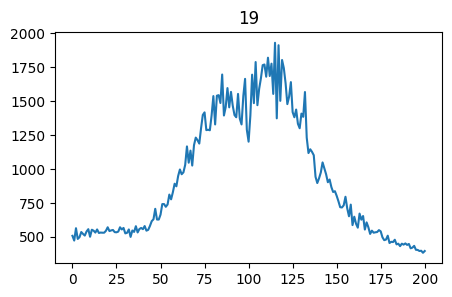

1/1 [==============================] - 0s 14ms/step


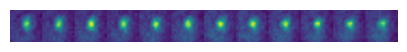

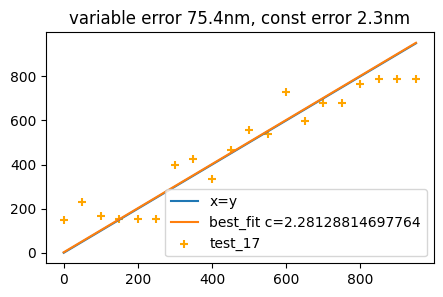

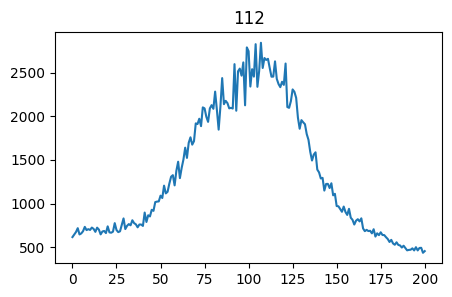

1/1 [==============================] - 0s 14ms/step


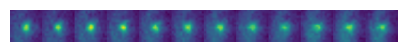

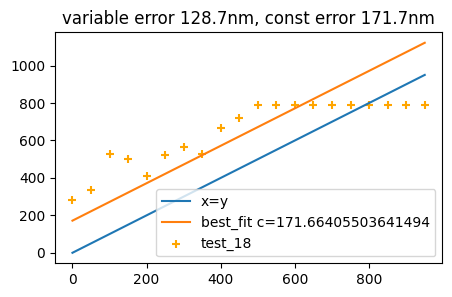

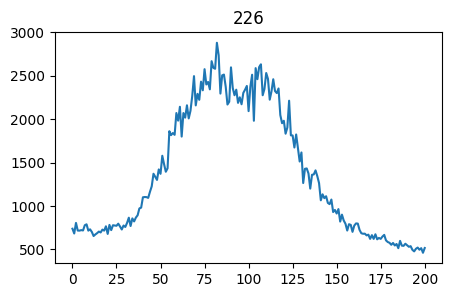

1/1 [==============================] - 0s 14ms/step


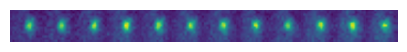

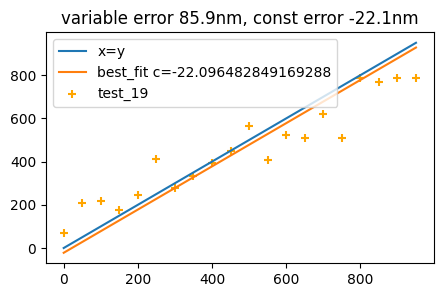

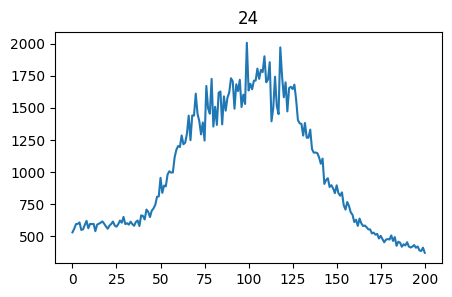

1/1 [==============================] - 0s 14ms/step


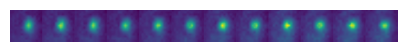

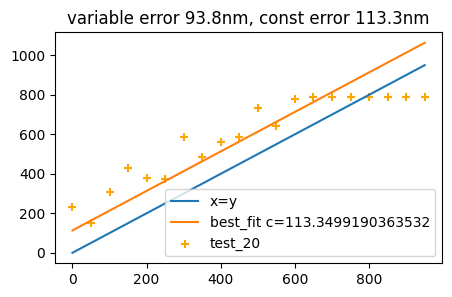

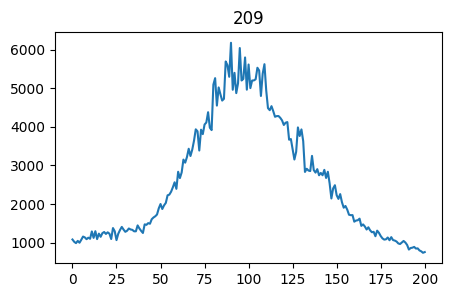

1/1 [==============================] - 0s 14ms/step


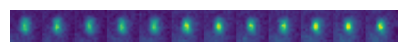

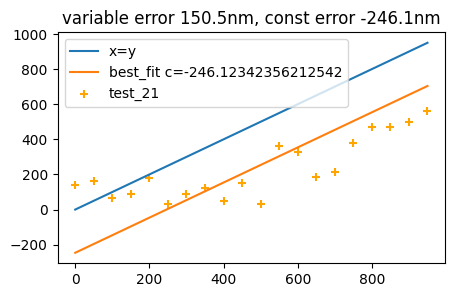

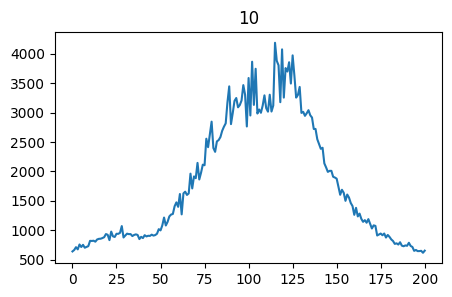

1/1 [==============================] - 0s 14ms/step


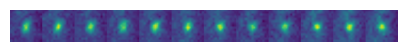

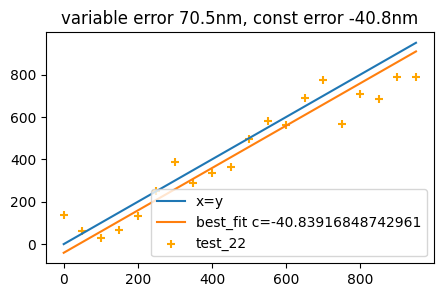

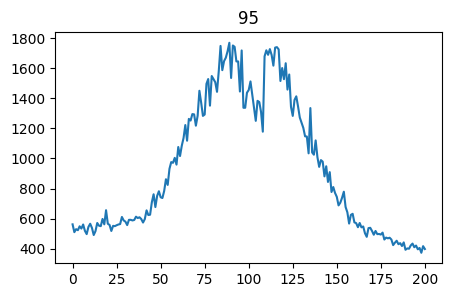

1/1 [==============================] - 0s 14ms/step


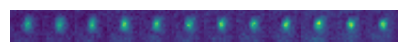

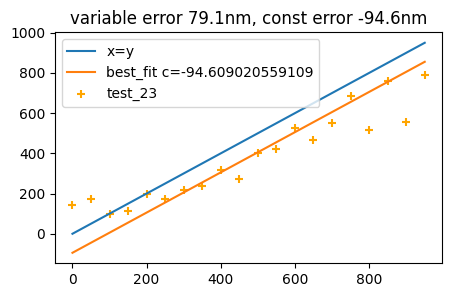

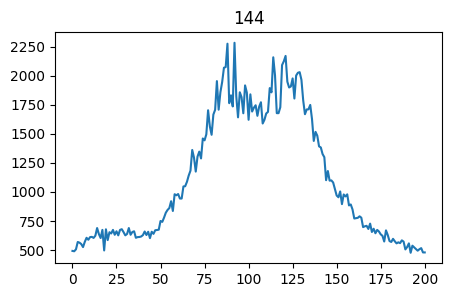

Mean offset 101.574


In [25]:
from sklearn.metrics import mean_absolute_error
import scipy.optimize as opt

plt.rcParams['figure.figsize'] = [5, 3]

def chunk_dataset(train, z):
    splits = [0] + list(np.argwhere(np.diff(z.squeeze()) < 0).flatten()+1) + [inputs[0].shape[0]]
    for i in range(len(splits)-1):
        start = splits[i]
        end = splits[i+1]
        yield (train[0][start:end], train[1][start:end]), z[start:end]

from tqdm import tqdm

from scipy.interpolate import UnivariateSpline
from data.align_psfs import norm_zero_one
UPSCALE_RATIO = 10
def find_peak(psf):
    if psf.ndim == 4:
        psf = psf.mean(axis=-1)
    x = np.arange(psf.shape[0]) * Z_STEP
    inten = norm_zero_one(psf.max(axis=(1,2)))
#   prev 0.8
    cs = UnivariateSpline(x, inten, k=3, s=1.25)

    x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP
    
    peak = x_ups[np.argmax(cs(x_ups))] 
    
#     plt.plot(x-peak, inten, label='raw')
#     plt.plot(x_ups-peak, cs(x_ups), label='fit')
#     plt.legend()
#     plt.show()
    return peak

def bestfit_error(z_true, z_pred):

    def linfit(x, c):
        return x + c

    x = z_true.squeeze()
    y = z_pred.squeeze()
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')

    error = mean_absolute_error(y_fit, y)
    return error, popt[0]


res_offsets = []


for name, dataset in [
#     ('train', (X_train_preproc, y_train)), 
#     ('val', (X_val_preproc, y_val)), 
    ('test', (X_test_preproc, y_test))]:
    inputs, z = dataset
    for i, (inp, true_zs) in enumerate(chunk_dataset(*dataset)):
        pred_zs = model.predict(inp)
        show_psf_axial(inp[0].mean(axis=-1), '', 1)
        find_peak(inp[0])
        
        error, offset = bestfit_error(true_zs, pred_zs)
        res_offsets.append(abs(offset))
#         error = mean_absolute_error(true_zs, pred_zs)
        plt.title(f'variable error {round(error, 1)}nm, const error {round(offset, 1)}nm')
        plt.scatter(true_zs, pred_zs, label=f'{name}_{i}', marker='+', c='orange')
        plt.legend()
        plt.show()
        if name == 'val':
            idx = val_idx
        else:
            idx = test_idx
        psf_idx = idx[i]
        psf = psfs[psf_idx]
        plt.plot(psf.max(axis=(1,2,3)))
        plt.title(str(psf_idx))
        plt.show()

print('Mean offset', round(np.mean(res_offsets), 3))
    


In [26]:
import pandas as pd
import h5py
import numpy as np

# MQ_DATA
dirname = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/'
locs = 'storm_1_MMStack_Default.ome_locs.hdf5'
spots = 'storm_1_MMStack_Default.ome_spots.hdf5'

# FD-DEEPLOC-data

dirname = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/demo2_FD_astig_NPC/'
locs = 'roi_startpos_810_790_split.ome_locs.hdf5'
spots = 'roi_startpos_810_790_split.ome_spots.hdf5'

all_locs = pd.read_hdf(dirname+locs, key='locs')
picked_locs = pd.read_hdf(dirname+locs.replace('_locs', '_locs_picked'), key='locs')

with h5py.File(dirname+spots, 'r') as f:
    spots = np.array(f['spots'])

print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


(257156, 12)
(257156, 12)
(257156, 15, 15)


In [27]:
import pandas as pd
df = pd.read_csv('/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/demo2_FD_astig_NPC/demo2_FD-DeepLoc_roi_startpos_810_790.csv')

In [28]:
df['x'] = df['xnano']/110
df['y'] = df['ynano']/110

In [29]:

# Check values in base image vs spots
# from PIL import Image

# d = Image.open('/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/storm_1_MMStack_Default.ome.tif')
# print(d.n_frames)
# d.seek(200)
# np.array(d).max()



In [30]:
# MQ_data_only
if 'demo2_FD_astig_NPC' in dirname:
    xlim = 100, 125
    ylim = 50, 75
    l2 = picked_locs[(xlim[0]<picked_locs['x']) & (xlim[1]>picked_locs['x']) & (ylim[0]<picked_locs['y']) & (ylim[1]>picked_locs['y'])]
    all_locs = all_locs.iloc[l2.index]
    picked_locs = all_locs
    spots = spots[l2.index]


print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


(6765, 12)
(6765, 12)
(6765, 15, 15)


In [31]:
if all_locs.shape[0] == picked_locs.shape[0]:
    idx = np.arange(all_locs.shape[0])
else:
    all_keys = list(all_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1))
    picked_keys = picked_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1)
    idx = [all_keys.index(k) for k in picked_keys]

exp_psfs = spots[idx]
print(exp_psfs.shape, picked_locs.shape)
print(exp_psfs.min(), exp_psfs.max())
try:
    print(psfs.min(), psfs.max())
    print(psfs.dtype, exp_psfs.dtype)
except NameError:
    pass

(6765, 15, 15) (6765, 12)
161.0 830.0
174 10323
uint16 float32


In [32]:
import matplotlib.pyplot as plt
from data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(exp_psfs[0:100]))
plt.show()

Rows 10 Cols 10 n_spaces 100 n_psfs 100
10


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sns.scatterplot(data=picked_locs, x='x', y='y', alpha=0.01)
plt.xlim((100, 125))
plt.ylim((50, 75))
plt.show()

In [ ]:
import pickle
import keras

# with open('./scalers.p', 'rb') as f:
#     preprocessors = pickle.load(f)

# model = keras.models.load_model('./latest_model/')

# datagen = preprocessors['psfs']
# coords_scaler = preprocessors['coords']

In [ ]:
print(exp_psfs.min(), exp_psfs.max())
print(psfs.min(), psfs.max())

exp_coords = np.zeros((exp_psfs.shape[0], X_train[1].shape[1]))

exp_data = [exp_psfs, exp_coords]

resize_psfs(exp_data)

exp_data[0] = datagen.standardize(exp_data[0])

print(exp_psfs_preproc.min(), exp_psfs_preproc.max())
print(X_train[0].min(), X_train[0].max())
# print(exp_psfs_preproc.min(), exp_psfs_preproc.max())
# print(X_train_preproc[0].min(), X_train_preproc[0].max())
# print(exp_coords_preproc.min(), exp_coords_preproc.max())
# print(exp_psfs_preproc.shape, exp_coords_preproc.shape)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(exp_psfs_preproc.mean(axis=-1)[0:200]))
plt.show()


In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 3]
print(exp_psfs.min(), exp_psfs.max())


pred_z = model.predict(exp_data)
print(pred_z[0:10])
sns.histplot(pred_z.squeeze())
plt.show()